In [1]:
import os
import dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from distributed.diagnostics import MemorySampler
from dask_ml.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import glob
from dask_ml.preprocessing import Categorizer
clusters = LocalCluster(n_workers=5)
client = Client(clusters)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 62.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44407,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 62.71 GiB
Comm: tcp://127.0.0.1:34327,Total threads: 4
Dashboard: http://127.0.0.1:39553/status,Memory: 12.54 GiB
Nanny: tcp://127.0.0.1:33445,


In [4]:
files = glob.glob('/media/vineeth/6TB_Volume/DataRepo/KitsuneNetworkAttackDataset/SYN DoS/SYN_DoS_dataset.csv')
labels = glob.glob('/media/vineeth/6TB_Volume/DataRepo/KitsuneNetworkAttackDataset/SYN DoS/SYN_DoS_labels.csv')

In [5]:
scalar = StandardScaler()
column_names= ['feature{}'.format(i) for i in range(115)]
ddf = dd.read_csv(files[0], names=column_names, header=None)
ddf = scalar.fit_transform(ddf)
ddf_label = dd.read_csv(labels[0])
ddf_label = ddf_label.drop(labels='Unnamed: 0', axis=1)
ddf_label = ddf_label.rename(columns={'x':'label'})
ddf = ddf.astype(np.float32)
ddf = ddf.repartition(npartitions=1)
# ddf_label = ddf_label.repartition(npartitions=ddf.npartitions)
ddf = ddf.reset_index(drop=True)
ddf_label = ddf_label.reset_index(drop=True)
# does not work: why? dd.concat([ddf, ddf_label], interleave_partitions=True, axis=1)
ddf = ddf.repartition(npartitions=1)
ddf_label = ddf_label.repartition(npartitions=1)
ddf = ddf.assign(label = ddf_label.label)
ddf = ddf.repartition(partition_size='100MB')
X, y = ddf.iloc[:, :-1], ddf["label"]
ddf.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,label
0,-2.389034,1.798879,-1.691902,-2.716523,1.801234,-1.698936,-2.995070,1.802670,-1.705091,-3.083630,...,-0.001865,-0.002241,-2.628343,1.021873,-1.225883,0.869208,-1.344684,-0.001864,-0.002106,0
1,-2.349951,-0.079282,0.839813,-2.688985,-0.081453,0.842204,-2.984753,-0.084324,0.844467,-3.082559,...,-0.001865,-0.002241,-2.628343,-1.119532,-1.225883,-1.360818,-1.344684,-0.001864,-0.002106,0
2,-2.310921,0.547112,0.558280,-2.661469,0.546314,0.559716,-2.974440,0.544742,0.561136,-3.081488,...,-0.001865,-0.002241,-2.628189,1.021873,-1.225883,0.869208,-1.344684,-0.001864,-0.002106,0
3,-2.271847,-0.079273,0.839813,-2.633934,-0.081448,0.842204,-2.964124,-0.084322,0.844467,-3.080418,...,-0.001865,-0.002241,-2.628189,-1.119532,-1.225883,-1.360818,-1.344684,-0.001864,-0.002106,0
4,-2.232865,0.296708,0.738405,-2.606438,0.295300,0.740475,-2.953814,0.293147,0.742456,-3.079347,...,-0.001865,-0.002241,-2.628035,1.021873,-1.225883,0.869208,-1.344684,-0.001864,-0.002106,0


In [10]:
from dask_ml.decomposition import PCA
pca = PCA(n_components=10)
X = X.to_dask_array(lengths=True)
principal_components = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.2939269  0.21820086 0.12962439 0.05738863 0.04871222 0.04426218
 0.04251963 0.02418171 0.02114389 0.01769645]


In [14]:
y = y.to_dask_array(lengths=True)

In [16]:
check.value_counts(normalize=True)

label
0        0.99746
1        0.00254
dtype: float64

<h1> Training using XGB </h1>

In [15]:
from dask_ml.model_selection import train_test_split
import xgboost as xgb

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    principal_components, y, test_size=0.3, shuffle=True, random_state=21
)

# Create the XGBoost DMatrix for our training and testing splits
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)
dtest = xgb.dask.DaskDMatrix(client, X_test, y_test)

# Set model parameters (XGBoost defaults)
params = {
    "max_depth": 6,
    "gamma": 0,
    "eta": 0.3,
    "min_child_weight": 30,
    "objective": "reg:squarederror",
    "grow_policy": "depthwise",
    "tree_method": "hist",
    "verbosity": 1
}

In [20]:
%%time 
# train the model
output = xgb.dask.train(
    client, params, dtrain, num_boost_round=100,
    evals=[(dtrain, 'train')]
)

[08:20:51] task [xgboost.dask]:tcp://127.0.0.1:42123 got new rank 0
[08:20:51] task [xgboost.dask]:tcp://127.0.0.1:46771 got new rank 1
[08:20:51] task [xgboost.dask]:tcp://127.0.0.1:34327 got new rank 2
[08:20:51] task [xgboost.dask]:tcp://127.0.0.1:43577 got new rank 3
[08:20:51] task [xgboost.dask]:tcp://127.0.0.1:38247 got new rank 4


[0]	train-rmse:0.35125
[1]	train-rmse:0.24790
[2]	train-rmse:0.17618
[3]	train-rmse:0.12722
[4]	train-rmse:0.09428
[5]	train-rmse:0.07281
[6]	train-rmse:0.05953
[7]	train-rmse:0.05174
[8]	train-rmse:0.04745
[9]	train-rmse:0.04518
[10]	train-rmse:0.04394
[11]	train-rmse:0.04333
[12]	train-rmse:0.04297
[13]	train-rmse:0.04276
[14]	train-rmse:0.04266
[15]	train-rmse:0.04259
[16]	train-rmse:0.04251
[17]	train-rmse:0.04246
[18]	train-rmse:0.04242
[19]	train-rmse:0.04237
[20]	train-rmse:0.04232
[21]	train-rmse:0.04227
[22]	train-rmse:0.04224
[23]	train-rmse:0.04220
[24]	train-rmse:0.04219
[25]	train-rmse:0.04214
[26]	train-rmse:0.04209
[27]	train-rmse:0.04204
[28]	train-rmse:0.04200
[29]	train-rmse:0.04196
[30]	train-rmse:0.04194
[31]	train-rmse:0.04190
[32]	train-rmse:0.04187
[33]	train-rmse:0.04184
[34]	train-rmse:0.04182
[35]	train-rmse:0.04178
[36]	train-rmse:0.04175
[37]	train-rmse:0.04173
[38]	train-rmse:0.04171
[39]	train-rmse:0.04168
[40]	train-rmse:0.04162
[41]	train-rmse:0.04159
[4

In [21]:
from sklearn.metrics import roc_curve
y_hat = xgb.dask.predict(client, output, X_test).persist()
y_test, y_hat = dask.compute(y_test, y_hat)
fpr, tpr, _ = roc_curve(y_test, y_hat)

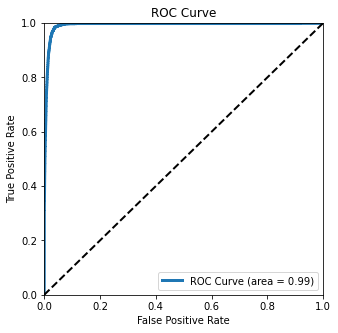

In [22]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

In [19]:
# confusion matrix
y_hat_class_labels = (y_hat > 0.5).astype(int)

In [21]:
y_test

15048      0
163235     0
193617     0
83349      0
9723       0
          ..
2743097    1
2618831    0
2716129    0
2629774    0
2745976    0
Name: label, Length: 830307, dtype: int64

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_hat_class_labels)

array([[828184,      2],
       [     1,   2120]])

In [26]:
client.close()